<a href="https://colab.research.google.com/github/banshee0716/Financial-Big-Data-Analysis/blob/master/%E9%87%91%E8%9E%8D%E6%95%B8%E6%93%9A%E5%88%86%E6%9E%90_W2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


##API part

In [2]:
def get_single_stock_data(stock_code):
    """
    Fetch and filter stock data for a specific stock from the TWSE API.

    Args:
    stock_code (str): The stock code for the desired company (e.g., '2330' for TSMC).

    Returns:
    dict: Stock data for the requested stock code in the specified format, or None if not found.
    """
    url = "https://openapi.twse.com.tw/v1/exchangeReport/STOCK_DAY_ALL"

    # Send GET request
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        # Iterate and filter stock data for the specific stock code
        for item in data:
            if item['Code'] == stock_code:
                # Return filtered data for the specified stock
                return {
                    'Code': item['Code'],
                    'Name': item['Name'],
                    'TradeVolume': item['TradeVolume'],
                    'TradeValue': item['TradeValue'],
                    'OpeningPrice': item['OpeningPrice'],
                    'HighestPrice': item['HighestPrice'],
                    'LowestPrice': item['LowestPrice'],
                    'ClosingPrice': item['ClosingPrice'],
                    'Change': item['Change'],
                    'Transaction': item['Transaction']
                }
        return None  # If stock code is not found
    else:
        print(f"Failed to retrieve data: {response.status_code}")
        return None


# 新增的函數：找出前五名OpeningPrice - ClosingPrice差異最大的股票
def get_top_5_stocks_by_price_diff():
    """
    Fetch all stock data and return the top 5 stocks with the largest difference between OpeningPrice and ClosingPrice.

    Returns:
    List of dicts: Top 5 stocks with the highest difference.
    """
    url = "https://openapi.twse.com.tw/v1/exchangeReport/STOCK_DAY_ALL"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        stock_diffs = []

        # 計算每支股票的開盤價與收盤價差異
        for item in data:
            try:
                opening_price = float(item['OpeningPrice'])
                closing_price = float(item['ClosingPrice'])
                price_diff = abs(opening_price - closing_price)
                stock_diffs.append({
                    'Code': item['Code'],
                    'Name': item['Name'],
                    'PriceDiff': price_diff,
                    'OpeningPrice': opening_price,
                    'ClosingPrice': closing_price
                })
            except ValueError:
                continue

        # 按照開盤價與收盤價差異進行排序，取前五名
        top_5_stocks = sorted(stock_diffs, key=lambda x: x['PriceDiff'], reverse=True)[:5]

        # 返回前五名股票資料
        return top_5_stocks
    else:
        print(f"Failed to retrieve data: {response.status_code}")
        return None

# 使用matplotlib進行可視化
def visualize_top_5_stocks(top_5_stocks):
    """
    Visualize the top 5 stocks with the largest price difference using a bar chart.

    Args:
    top_5_stocks (list of dicts): The top 5 stocks with the highest price differences.
    """
    # 股票代碼
    stock_codes = [stock['Code'] for stock in top_5_stocks]
    # 開盤價與收盤價的差異
    price_diffs = [stock['PriceDiff'] for stock in top_5_stocks]

    # 畫條狀圖
    plt.figure(figsize=(10, 6))
    plt.bar(stock_codes, price_diffs, color='skyblue')
    plt.xlabel('Stock Code')
    plt.ylabel('Price Difference (Opening - Closing)')
    plt.title('Top 5 Stocks with Largest Price Difference')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


{'Code': '2330', 'Name': '台積電', 'TradeVolume': '15399658', 'TradeValue': '15013916758', 'OpeningPrice': '971.00', 'HighestPrice': '977.00', 'LowestPrice': '971.00', 'ClosingPrice': '977.00', 'Change': '4.0000', 'Transaction': '26106'}


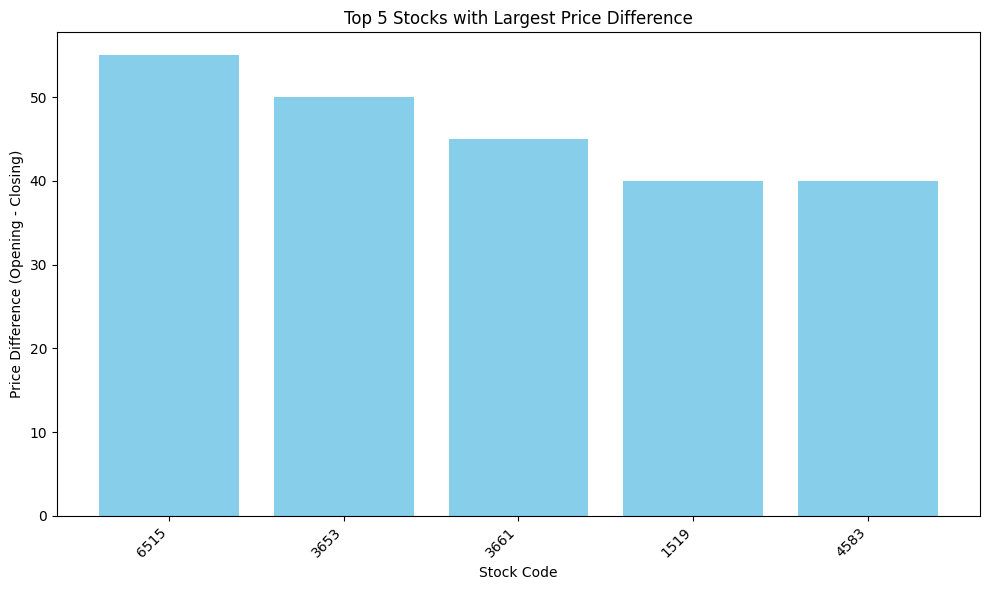

In [3]:
# Example usage: Fetch data for TSMC (code: 2330)
tsmc_data = get_single_stock_data("2330")
if tsmc_data:
    print(tsmc_data)

# 執行並顯示結果
top_5_stocks = get_top_5_stocks_by_price_diff()
if top_5_stocks:
    visualize_top_5_stocks(top_5_stocks)


##爬蟲part




In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

def get_stock_data(stock_code):
    url = f"https://tw.stock.yahoo.com/quote/{stock_code}.TW"
    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract specific data points
        date = datetime.now().strftime("%Y%m%d")
        time = datetime.now().strftime("%H:%M")

        # Find the stock price
        price_element = soup.find('span', {'class': 'Fz(32px) Fw(b) Lh(1) Mend(16px) D(f) Ai(c) C($c-trend-up)'})
        price = price_element.text if price_element else "N/A"

        ul = soup.find('ul', class_='D(f) Fld(c) Flw(w) H(192px) Mx(-16px)')
        data = {}
        if ul:
            for li in ul.find_all('li', class_='price-detail-item'):
                label = li.find('span', class_='C(#232a31)').text
                value = li.find('span', class_='Fw(600)').text
                data[label] = value

        # 創建DataFrame
        df = pd.DataFrame({
            '日期': [date],
            '時間': [time],
            '成交': [price],
            '買進': [data.get('買進', 'N/A')],
            '賣出': [data.get('賣出', 'N/A')],
            '漲跌': [data.get('漲跌', 'N/A')],
            '漲跌幅': [data.get('漲跌幅', 'N/A')],
            '成交量(張)': [data.get('成交量', 'N/A')],
            '昨收': [data.get('參考價', 'N/A')],
            '開盤': [data.get('開盤', 'N/A')],
            '最高': [data.get('最高', 'N/A')],
            '最低': [data.get('最低', 'N/A')],
            '振幅': [data.get('振幅', 'N/A')],
            '成交金額': [data.get('成交金額', 'N/A')]
        })

        return df
    else:
        print(f"無法連接到網站，狀態碼: {response.status_code}")
        return None

In [5]:
stock_df = get_stock_data(3231)

# 顯示DataFrame

stock_df

# 如果需要將資料儲存到CSV文件，可以使用以下命令
# stock_df.to_csv(f'{stock_code}_stock_data.csv', index=False)

,日期,時間,成交,買進,賣出,漲跌,漲跌幅,成交量(張),昨收,開盤,最高,最低,振幅,成交金額
0,20240924,04:05,102.0,N/A,N/A,0.50,0.49%,N/A,N/A,101.5,102.0,100.5,1.48%,N/A
